# Comparison with scikit-image
With scikit-image 0.18.0, quite some 3D processing capabilities were introduced. Let's see how they perform in comparison with our OpenCL stuff. When doing similar comparisons with ImageJ, we saw more performance benefits when GPU-accelerating 3D operations compared to 2D operations. https://clij.github.io/clij-benchmarking/benchmarking_operations_jmh

In [1]:
import pyclesperanto_prototype as cle
from skimage import filters
import time

In [2]:
cle.select_device('RTX')

<GeForce RTX 2070 on Platform: NVIDIA CUDA (1 refs)>

In [3]:
# test data
import numpy as np

test_image = np.random.random([100, 512, 512])

structuring_element = np.ones([3,3,3])

sigma = 10
# note: benchmarking results vary heavily depending on image size, kernel size, used operations, parameters and used hardware. 

# Gaussian blur

In [4]:
# convolve with scikit-image
result_image = None

for i in range(0, 10):
    start_time = time.time()
    result_image = filters.gaussian(test_image, output=result_image, sigma=sigma)
    print("skimage Gaussian duration: " + str(time.time() - start_time))
    

skimage Gaussian duration: 2.707399368286133
skimage Gaussian duration: 2.6221368312835693
skimage Gaussian duration: 2.619218587875366
skimage Gaussian duration: 2.670463800430298
skimage Gaussian duration: 2.755244255065918
skimage Gaussian duration: 2.6202399730682373
skimage Gaussian duration: 2.6385498046875
skimage Gaussian duration: 2.647368907928467
skimage Gaussian duration: 2.750206232070923
skimage Gaussian duration: 2.792012929916382


In [5]:
# convolve with pyclesperanto
result_image = None

test_image_gpu = cle.push_zyx(test_image)

for i in range(0, 10):
    start_time = time.time()
    result_image = cle.gaussian_blur(test_image_gpu, result_image, sigma_x=sigma, sigma_y=sigma, sigma_z=sigma)
    print("pyclesperanto Gaussian duration: " + str(time.time() - start_time))

pyclesperanto Gaussian duration: 0.10341858863830566
pyclesperanto Gaussian duration: 0.06169939041137695
pyclesperanto Gaussian duration: 0.05884957313537598
pyclesperanto Gaussian duration: 0.057170867919921875
pyclesperanto Gaussian duration: 0.05924558639526367
pyclesperanto Gaussian duration: 0.05806756019592285
pyclesperanto Gaussian duration: 0.05553746223449707
pyclesperanto Gaussian duration: 0.05892133712768555
pyclesperanto Gaussian duration: 0.05788159370422363
pyclesperanto Gaussian duration: 0.05892372131347656


# Thresholding
pyclesperanto thresholding_otsu uses scikit-image under the hood.It just determines the histogram differently.

In [6]:
# thresholding with scikit-image
result_image = None

for i in range(0, 10):
    start_time = time.time()
    threshold = filters.threshold_otsu(test_image)
    result_image = test_image >= threshold
    print("skimage thresholding duration: " + str(time.time() - start_time))

skimage thresholding duration: 0.4194908142089844
skimage thresholding duration: 0.39594578742980957
skimage thresholding duration: 0.38744163513183594
skimage thresholding duration: 0.4936802387237549
skimage thresholding duration: 0.3889584541320801
skimage thresholding duration: 0.39345550537109375
skimage thresholding duration: 0.4118978977203369
skimage thresholding duration: 0.48174476623535156
skimage thresholding duration: 0.3894321918487549
skimage thresholding duration: 0.38197827339172363


In [7]:
# thresholding with pyclesperanto
result_image = None

test_image_gpu = cle.push_zyx(test_image)

for i in range(0, 10):
    start_time = time.time()
    result_image = cle.threshold_otsu(test_image_gpu, result_image)
    print("pyclesperanto thresholding duration: " + str(time.time() - start_time))

pyclesperanto thresholding duration: 0.06671977043151855
pyclesperanto thresholding duration: 0.047235965728759766
pyclesperanto thresholding duration: 0.046285390853881836
pyclesperanto thresholding duration: 0.041047096252441406
pyclesperanto thresholding duration: 0.03786039352416992
pyclesperanto thresholding duration: 0.039893150329589844
pyclesperanto thresholding duration: 0.04295015335083008
pyclesperanto thresholding duration: 0.04485011100769043
pyclesperanto thresholding duration: 0.037506818771362305
pyclesperanto thresholding duration: 0.043187618255615234


# Expand labels / extend labels 
The following example is taken from https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_expand_labels.html

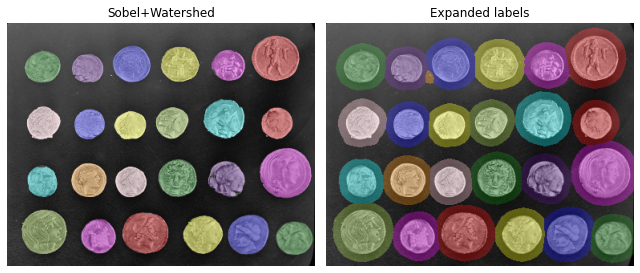

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters import sobel
from skimage.measure import label
from skimage.segmentation import watershed, expand_labels
from skimage.color import label2rgb
from skimage import data

coins = data.coins()

# Make segmentation using edge-detection and watershed.
edges = sobel(coins)

# Identify some background and foreground pixels from the intensity values.
# These pixels are used as seeds for watershed.
markers = np.zeros_like(coins)
foreground, background = 1, 2
markers[coins < 30.0] = background
markers[coins > 150.0] = foreground

ws = watershed(edges, markers)
seg1 = label(ws == foreground)

expanded = expand_labels(seg1, distance=10)

# Show the segmentations.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5),
                         sharex=True, sharey=True)

color1 = label2rgb(seg1, image=coins, bg_label=0)
axes[0].imshow(color1)
axes[0].set_title('Sobel+Watershed')

color2 = label2rgb(expanded, image=coins, bg_label=0)
axes[1].imshow(color2)
axes[1].set_title('Expanded labels')

for a in axes:
    a.axis('off')
fig.tight_layout()
plt.show()

In [9]:
# expanding labels with scikit-image
for i in range(0, 10):
    start_time = time.time()
    expanded = expand_labels(seg1, distance=10)
    print("skimage expand_labels duration: " + str(time.time() - start_time))

skimage expand_labels duration: 0.02448248863220215
skimage expand_labels duration: 0.01591634750366211
skimage expand_labels duration: 0.014971017837524414
skimage expand_labels duration: 0.015993833541870117
skimage expand_labels duration: 0.013938665390014648
skimage expand_labels duration: 0.010986089706420898
skimage expand_labels duration: 0.011968851089477539
skimage expand_labels duration: 0.014927387237548828
skimage expand_labels duration: 0.01396799087524414
skimage expand_labels duration: 0.011969566345214844


In [10]:
# expanding labels with pyclesperanto
labels_gpu = cle.push_zyx(seg1)

expanded = None

for i in range(0, 10):
    start_time = time.time()
    expanded = cle.extend_labels_with_maximum_radius(labels_gpu, expanded, 10)
    print("pyclesperanto extend_labels_with_maximum_radius duration: " + str(time.time() - start_time))

pyclesperanto extend_labels_with_maximum_radius duration: 0.027923107147216797
pyclesperanto extend_labels_with_maximum_radius duration: 0.007980823516845703
pyclesperanto extend_labels_with_maximum_radius duration: 0.014960527420043945
pyclesperanto extend_labels_with_maximum_radius duration: 0.016959190368652344
pyclesperanto extend_labels_with_maximum_radius duration: 0.014955282211303711
pyclesperanto extend_labels_with_maximum_radius duration: 0.014960289001464844
pyclesperanto extend_labels_with_maximum_radius duration: 0.01296687126159668
pyclesperanto extend_labels_with_maximum_radius duration: 0.01196908950805664
pyclesperanto extend_labels_with_maximum_radius duration: 0.01296377182006836
pyclesperanto extend_labels_with_maximum_radius duration: 0.013962984085083008


# Mean filter

In [11]:
# mean filter with scikit-image
result_image = None

for i in range(0, 10):
    start_time = time.time()
    result_image = filters.rank.mean(test_image, selem=structuring_element, out=result_image)
    print("skimage rank.mean duration: " + str(time.time() - start_time))

c:\users\rober\miniconda3\lib\site-packages\skimage\filters\rank\generic.py:278: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  image, selem, out, mask, n_bins = _handle_input_3D(image, selem, out, mask,


skimage rank.mean duration: 40.231796741485596
skimage rank.mean duration: 39.318931341171265
skimage rank.mean duration: 39.64369988441467
skimage rank.mean duration: 39.56651067733765
skimage rank.mean duration: 39.40237808227539
skimage rank.mean duration: 39.62476420402527
skimage rank.mean duration: 39.404463052749634
skimage rank.mean duration: 39.40227293968201
skimage rank.mean duration: 39.68279695510864
skimage rank.mean duration: 43.492011070251465


In [12]:
# mean filter with pyclesperanto
result_image = None

test_image_gpu = cle.push_zyx(test_image)

for i in range(0, 10):
    start_time = time.time()
    result_image = cle.mean_box(test_image_gpu, result_image, radius_x=10, radius_y=10, radius_z=10)
    print("pyclesperanto mean_box duration: " + str(time.time() - start_time))

pyclesperanto mean_box duration: 0.16867542266845703
pyclesperanto mean_box duration: 0.02494025230407715
pyclesperanto mean_box duration: 0.02438974380493164
pyclesperanto mean_box duration: 0.023015975952148438
pyclesperanto mean_box duration: 0.025038719177246094
pyclesperanto mean_box duration: 0.023128747940063477
pyclesperanto mean_box duration: 0.0229794979095459
pyclesperanto mean_box duration: 0.023415565490722656
pyclesperanto mean_box duration: 0.023169994354248047
pyclesperanto mean_box duration: 0.020495891571044922


In [14]:
# mean filter using convolve with pyclesperanto
result_image = None

test_image_gpu = cle.push_zyx(test_image)
structuring_element_gpu = cle.push_zyx(structuring_element)

for i in range(0, 10):
    start_time = time.time()
    result_image = cle.convolve(test_image_gpu, structuring_element_gpu, result_image)
    print("pyclesperanto convolve duration: " + str(time.time() - start_time))

pyclesperanto convolve duration: 0.14584589004516602
pyclesperanto convolve duration: 0.0
pyclesperanto convolve duration: 0.0010042190551757812
pyclesperanto convolve duration: 0.0
pyclesperanto convolve duration: 0.0009968280792236328
pyclesperanto convolve duration: 0.0
pyclesperanto convolve duration: 0.0009970664978027344
pyclesperanto convolve duration: 0.0
pyclesperanto convolve duration: 0.0
pyclesperanto convolve duration: 0.0009984970092773438
